## Import Necessary Libraries

In [1]:
import warnings

warnings.filterwarnings("ignore")
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics.pairwise import pairwise_distances
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.similarities import MatrixSimilarity
from scipy.sparse import csr_matrix

import implicit
from implicit import evaluation
# from implicit.evaluation import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from math import sqrt


## Load & Understand Dataset 

### Platform Content Dataset

- Check shape & head
- Check for Missing Values
- Remove Duplicate rows if present
- Check Stats with Describe. 

It can be noted that most the numerical columns are unique identifiers and statiscal measures don't provide any useful insights for them. Hence we would check it for categorical data.

In [2]:
# Check Shape & few rows
platform_content = pd.read_csv("./data/platform_content.csv")
print("Shape of Dataset : {}".format(platform_content.shape))

platform_content.head()

Shape of Dataset : (3122, 13)


,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [3]:
# Check data-types & missing values
platform_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       3122 non-null   int64 
 1   interaction_type      3122 non-null   object
 2   item_id               3122 non-null   int64 
 3   producer_id           3122 non-null   int64 
 4   producer_session_id   3122 non-null   int64 
 5   producer_device_info  680 non-null    object
 6   producer_location     680 non-null    object
 7   producer_country      680 non-null    object
 8   item_type             3122 non-null   object
 9   item_url              3122 non-null   object
 10  title                 3122 non-null   object
 11  text_description      3122 non-null   object
 12  language              3122 non-null   object
dtypes: int64(4), object(9)
memory usage: 317.2+ KB


In [4]:
# Check Missing values in terms of Percentage
pd.DataFrame(data={'% of Missing Values':round(platform_content.isnull().sum()/platform_content.isnull().count()*100,2)
                  }).sort_values(by='% of Missing Values',ascending=False)

,% of Missing Values
producer_device_info,78.22
producer_location,78.22
producer_country,78.22
event_timestamp,0.00
interaction_type,0.00
item_id,0.00
producer_id,0.00
producer_session_id,0.00
item_type,0.00
item_url,0.00


In [5]:
# Describe stats for Numerical Columns
platform_content.describe().T

,count,mean,std,min,25%,50%,75%,max
event_timestamp,3122.0,1.468804e+09,7.571512e+06,1.459193e+09,1.462369e+09,1.467136e+09,1.473873e+09,1.488308e+09
item_id,3122.0,3.284110e+16,5.383734e+18,-9.222795e+18,-4.660869e+18,4.436584e+16,4.745617e+18,9.222265e+18
producer_id,3122.0,3.984819e+17,4.387115e+18,-9.120686e+18,-1.578288e+18,-7.092877e+17,3.609194e+18,9.210531e+18
producer_session_id,3122.0,1.976675e+17,5.403753e+18,-9.212055e+18,-4.651280e+18,4.154103e+17,4.841644e+18,9.221043e+18


In [6]:
# Describe states for Categorical/Object Columns
platform_content.describe(include=['object']).T

,count,unique,top,freq
interaction_type,3122,2,content_present,3047
producer_device_info,680,114,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,71
producer_location,680,19,SP,533
producer_country,680,5,BR,613
item_type,3122,3,HTML,3101
item_url,3122,3029,https://medium.com/quality-functions/preventin...,8
title,3122,3011,Preventing Software Bugs from Ever Occurring -...,8
text_description,3122,3019,Bug Type 3: Missing Specifications Description...,8
language,3122,5,en,2264


In [7]:
# Check Unique values in all the columns
platform_content.nunique()

event_timestamp         3121
interaction_type           2
item_id                 3057
producer_id              252
producer_session_id     2017
producer_device_info     114
producer_location         19
producer_country           5
item_type                  3
item_url                3029
title                   3011
text_description        3019
language                   5
dtype: int64

In [8]:
# Check for Duplicates
platform_content[platform_content.duplicated()]

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language


#### Note : 

1. The describe function showed minimum values for few columns to be negative. 
2. Also, no duplicates where seen in the dataset.
3. Based on this, I decide to convert negative values to positive values by take absolute & recheck for duplicates.
4. This would help us create a consistent dataset
5. Some details about the producers have high percentage of missing values. Since we will not be using them, it's fine and we can ignore them later.

In [9]:
# Convert Columns to Absolute Values

platform_content['item_id'] = platform_content['item_id'].abs()
platform_content['producer_id'] = platform_content['producer_id'].abs()
platform_content['producer_session_id'] = platform_content['producer_session_id'].abs()

In [10]:
# Check for Duplicates Again
platform_content[platform_content.duplicated()]

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language


#### Note :

1. As we see that there are still no duplicates, we can make conclude safely that the above transformation is valid

#### Observations from the Platform Content

1. We have few columns with ~78% missing values, which will be hard to impute or use
2. We treated some negative values in the dataset
3. There are not duplicates in the dataset considering all columns together
4. From the Describe & N-Unique functions, we can see that some news/articles are published more than one time.
5. This might need to be handled while suggesting recommedations.
6. Also, the number of Unique Producers is ~250

### Consumer Transaction Dataset

- Check shape & head
- Check for Missing Values
- Remove Duplicate rows if present
- Check Stats with Describe. 

It can be noted that most the numerical columns are unique identifiers and statiscal measures don't provide any useful insights for them. Hence we would check it for categorical data.

In [11]:
# Check Shape & few rows

consumer_trans = pd.read_csv("./data/consumer_transanctions.csv")
print("Shape of Dataset : {}".format(consumer_trans.shape))

consumer_trans.head()

Shape of Dataset : (72312, 8)


,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN


In [12]:
consumer_trans.tail()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
72307,1485190425,content_liked,-6590819806697898649,-9016528795238256703,8614469745607949425,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,MG,BR
72308,1485190425,content_watched,-5813211845057621660,102305705598210278,5527770709392883642,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
72309,1485190072,content_watched,-1999468346928419252,-9196668942822132778,-8300596454915870873,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,SP,BR
72310,1485190434,content_watched,-6590819806697898649,-9016528795238256703,8614469745607949425,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,MG,BR
72311,1485187988,content_watched,5669290109546991426,5713241217519616260,6704552481483665372,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR


In [13]:
# Check data-types & missing values

consumer_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       72312 non-null  int64 
 1   interaction_type      72312 non-null  object
 2   item_id               72312 non-null  int64 
 3   consumer_id           72312 non-null  int64 
 4   consumer_session_id   72312 non-null  object
 5   consumer_device_info  56918 non-null  object
 6   consumer_location     56907 non-null  object
 7   country               56918 non-null  object
dtypes: int64(3), object(5)
memory usage: 4.4+ MB


#### Note : 
- Cosumer Session ID is an object instead of Integer. There can be some data discripency.

In [14]:
# Check Missing values in terms of Percentage

pd.DataFrame(data={'% of Missing Values':round(consumer_trans.isnull().sum()/consumer_trans.isnull().count()*100,2)
                  }).sort_values(by='% of Missing Values',ascending=False)

,% of Missing Values
consumer_location,21.30
consumer_device_info,21.29
country,21.29
event_timestamp,0.00
interaction_type,0.00
item_id,0.00
consumer_id,0.00
consumer_session_id,0.00


In [15]:
# Check Unique values in all the columns
consumer_trans.nunique()

event_timestamp         68772
interaction_type            5
item_id                  2987
consumer_id              1895
consumer_session_id     28909
consumer_device_info     1090
consumer_location          71
country                    23
dtype: int64

In [16]:
# Describe stats for Numerical Columns
consumer_trans.describe().T

,count,mean,std,min,25%,50%,75%,max
event_timestamp,72312.0,1.470103e+09,7.258130e+06,1.457964e+09,1.464876e+09,1.468343e+09,1.474461e+09,1.488310e+09
item_id,72312.0,-3.033423e+16,5.344755e+18,-9.222795e+18,-4.726309e+18,1.893099e+16,4.441012e+18,9.222265e+18
consumer_id,72312.0,1.252026e+16,5.022333e+18,-9.223122e+18,-3.596627e+18,-1.088422e+17,3.766319e+18,9.210531e+18


In [17]:
# Describe states for Categorical/Object Columns
consumer_trans.describe(include=['object']).T

,count,unique,top,freq
interaction_type,72312,5,content_watched,61086
consumer_session_id,72312,28909,-1424527253526269635,182
consumer_device_info,56918,1090,Android - Native Mobile App,6761
consumer_location,56907,71,SP,40164
country,56918,23,BR,51396


In [18]:
# Check for Duplicates 

print("Number of Duplicated Rows : {}".format(consumer_trans[consumer_trans.duplicated()].shape))
consumer_trans[consumer_trans.duplicated()]

Number of Duplicated Rows : (11, 8)


,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
17376,1465600565,content_watched,-1101832997669013246,-6067316262393890508,-3337777501960829854,Android - Native Mobile App,SP,BR
34216,1468546087,content_watched,-7570652411388243006,8261378399174507610,-8130087990388931002,Android - Native Mobile App,SP,BR
38161,1468686847,content_watched,-1596335233529956315,4209517478660372522,-7907915538056273545,Android - Native Mobile App,SP,BR
39900,1470014443,content_watched,-8254222281357012124,8872819156169667456,-1543861209543571797,Android - Native Mobile App,SP,BR
40827,1470429814,content_watched,-6394075099886393346,5621833459783231486,-3639195041594850894,Android - Native Mobile App,MG,BR
42207,1469023286,content_watched,-8369610219380465981,3636910968448833585,-2391545252578053179,Android - Native Mobile App,TX,US
42661,1468862429,content_watched,7459643459148487877,-1443636648652872475,7279439813291705808,Android - Native Mobile App,SP,BR
43647,1470408237,content_watched,-8512461968928613053,-5380862725077089346,2703462416451811917,Android - Native Mobile App,SP,BR
46257,1471350218,content_watched,8482750322470893687,2542290381109225938,6842640776615996899,Android - Native Mobile App,SP,BR
63559,1480903939,content_watched,-6765871608738223618,8745559424774781326,-4700354216257792536,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,13,JP


#### Note : 

1. The describe function showed minimum values for few columns to be negative. 
2. Also, duplicates where seen in the dataset.
3. Based on this, I decide to convert negative values to positive values by take absolute & recheck for duplicates.
4. This would help us create a consistent dataset

In [19]:
# Convert Columns to Absolute Values

consumer_trans['item_id'] = consumer_trans['item_id'].abs()
consumer_trans['consumer_id'] = consumer_trans['consumer_id'].abs()

In [20]:
consumer_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       72312 non-null  int64 
 1   interaction_type      72312 non-null  object
 2   item_id               72312 non-null  int64 
 3   consumer_id           72312 non-null  int64 
 4   consumer_session_id   72312 non-null  object
 5   consumer_device_info  56918 non-null  object
 6   consumer_location     56907 non-null  object
 7   country               56918 non-null  object
dtypes: int64(3), object(5)
memory usage: 4.4+ MB


In [21]:
# Check for Duplicates Again

print("Number of Duplicated Rows : {}".format(consumer_trans[consumer_trans.duplicated()].shape))
consumer_trans[consumer_trans.duplicated()]

Number of Duplicated Rows : (11, 8)


,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
17376,1465600565,content_watched,1101832997669013246,6067316262393890508,-3337777501960829854,Android - Native Mobile App,SP,BR
34216,1468546087,content_watched,7570652411388243006,8261378399174507610,-8130087990388931002,Android - Native Mobile App,SP,BR
38161,1468686847,content_watched,1596335233529956315,4209517478660372522,-7907915538056273545,Android - Native Mobile App,SP,BR
39900,1470014443,content_watched,8254222281357012124,8872819156169667456,-1543861209543571797,Android - Native Mobile App,SP,BR
40827,1470429814,content_watched,6394075099886393346,5621833459783231486,-3639195041594850894,Android - Native Mobile App,MG,BR
42207,1469023286,content_watched,8369610219380465981,3636910968448833585,-2391545252578053179,Android - Native Mobile App,TX,US
42661,1468862429,content_watched,7459643459148487877,1443636648652872475,7279439813291705808,Android - Native Mobile App,SP,BR
43647,1470408237,content_watched,8512461968928613053,5380862725077089346,2703462416451811917,Android - Native Mobile App,SP,BR
46257,1471350218,content_watched,8482750322470893687,2542290381109225938,6842640776615996899,Android - Native Mobile App,SP,BR
63559,1480903939,content_watched,6765871608738223618,8745559424774781326,-4700354216257792536,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,13,JP


In [22]:
# Remove Duplicated Values 
print("Previous Dataset Size : {}".format(consumer_trans.shape))

consumer_trans = consumer_trans[~consumer_trans.duplicated()]

print("After Removing Duplicates Size : {}".format(consumer_trans.shape))

# Check Duplicates Again
consumer_trans[consumer_trans.duplicated()]

Previous Dataset Size : (72312, 8)
After Removing Duplicates Size : (72301, 8)


,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country


#### Note :

1. As we see that there are still same duplicates, we can make conclude safely that the above transformation for Absolute is valid
2. I also go forward and remove the duplicate values

#### Observations from the Consumer Transaction Content

1. The dataset is bigger than the platform dataset , which is logical
2. Few colums have ~20% missing values in categoring columns, we might need to think if these can be imputed.
3. We also checked for unique values and removed duplicate values.
4. We also converted some columns to absolute values safely.

## Exploratory Data Analysis for Platform Content

In [23]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency
# and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical
# variable.
# This function takes the numerical column as the input and returns the boxplots
# and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
def histogram_boxplot(feature, figsize=(15, 10), bins=None):
    """Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(
        feature, kde=F, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.distplot(
        feature, kde=False, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        np.mean(feature), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        np.median(feature), color="black", linestyle="-"
    )  # Add median to the histogram
    
    


def perc_on_bar(feature,data):
    """
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    """
    # Creating a countplot for the feature
    sns.set(rc={"figure.figsize": (15, 10)})
    ax = sns.countplot(x=feature, data=data)

    total = len(feature)  # length of the column
    for p in ax.patches:
        percentage = "{:.1f}%".format(
            100 * p.get_height() / total
        )  # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.1  # width of the plot
        y = p.get_y() + p.get_height()  # hieght of the plot
        ax.annotate(percentage, (x, y), size=14)  # annotate the percantage

    plt.show()  # show the plot
    
    


In [24]:
# Adding New Columns for Word Count & Length
platform_content["title_words"] = platform_content['title'].apply(lambda x : len(x.split()))
platform_content["title_len"] = platform_content['title'].apply(lambda x : len(x))

platform_content["text_words"] = platform_content['text_description'].apply(lambda x : len(x.split()))
platform_content["text_len"] = platform_content['text_description'].apply(lambda x : len(x))

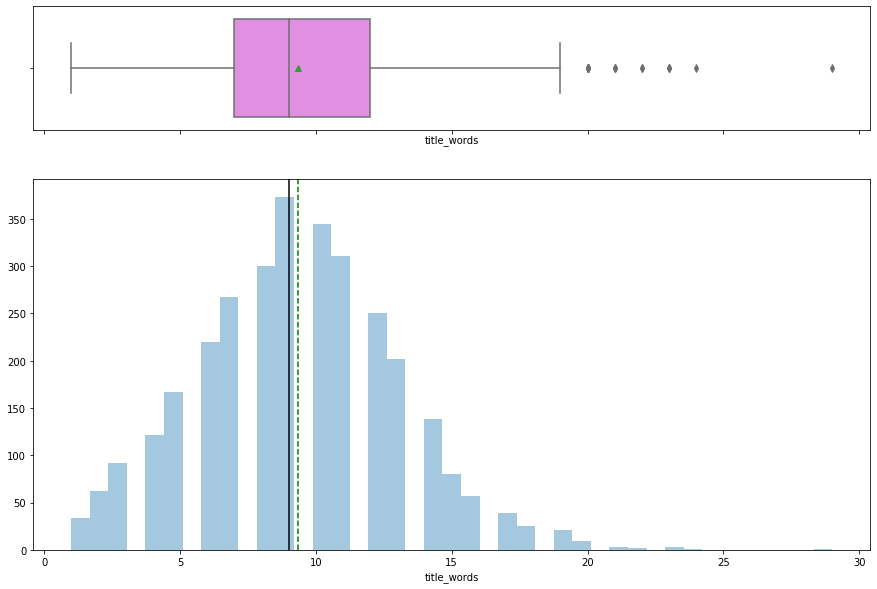

In [25]:
# Checking Distribution of Number of Words in Title
histogram_boxplot(platform_content["title_words"])

#### Observation :
- The distribution is almost normal with some outliers on the right side, making it slightly skewed.

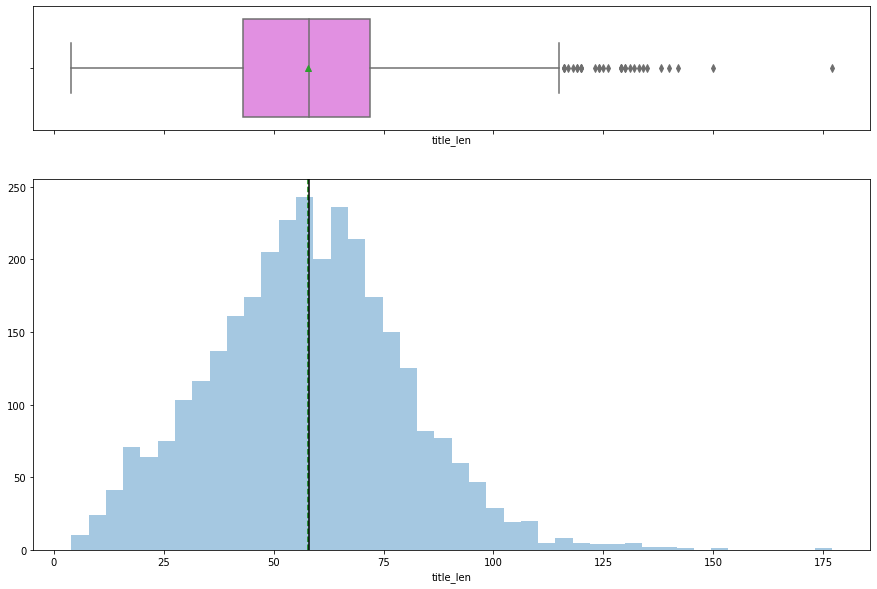

In [26]:
# Checking Distribution of Number of Characters in Title

histogram_boxplot(platform_content["title_len"])

#### Observation :
- The distribution is almost normal with some outliers on the right side, making it slightly skewed.
- The mean & median almost overlap, with peak b/w 5--75 character length

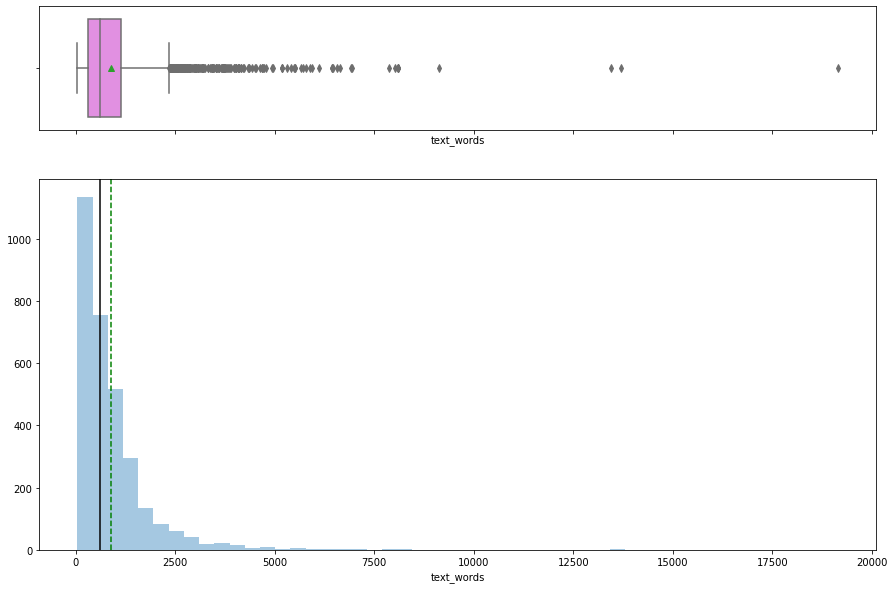

In [27]:
# Checking Distribution of Number of Words in Text Description

histogram_boxplot(platform_content["text_words"])

#### Observation :
- The number of words in Text Description is Right Skewed
- There are outliers as well for some articles

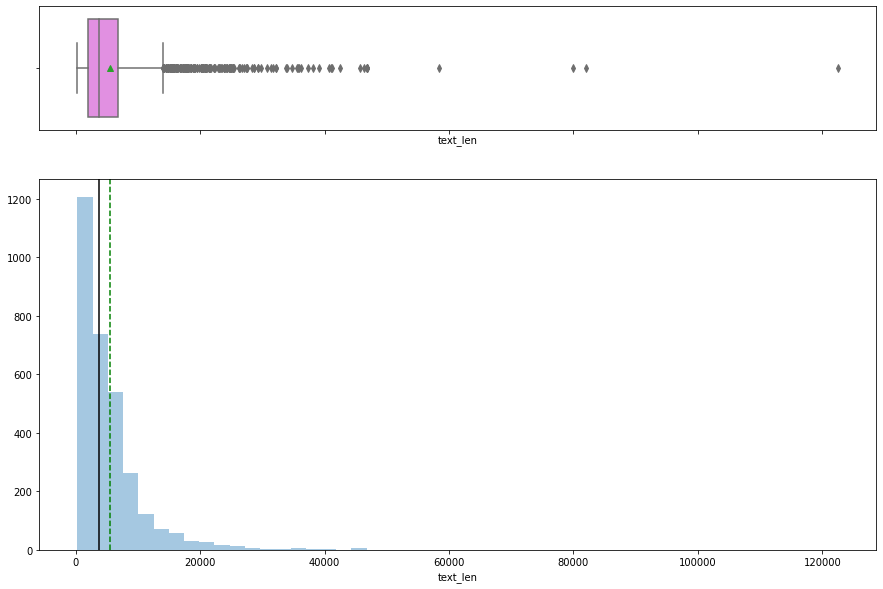

In [28]:
# Checking Distribution of Number of Characters in Title
histogram_boxplot(platform_content["text_len"])

#### Observation :
- The number of character in Text Description is Right Skewed
- There are outliers as well for some articles

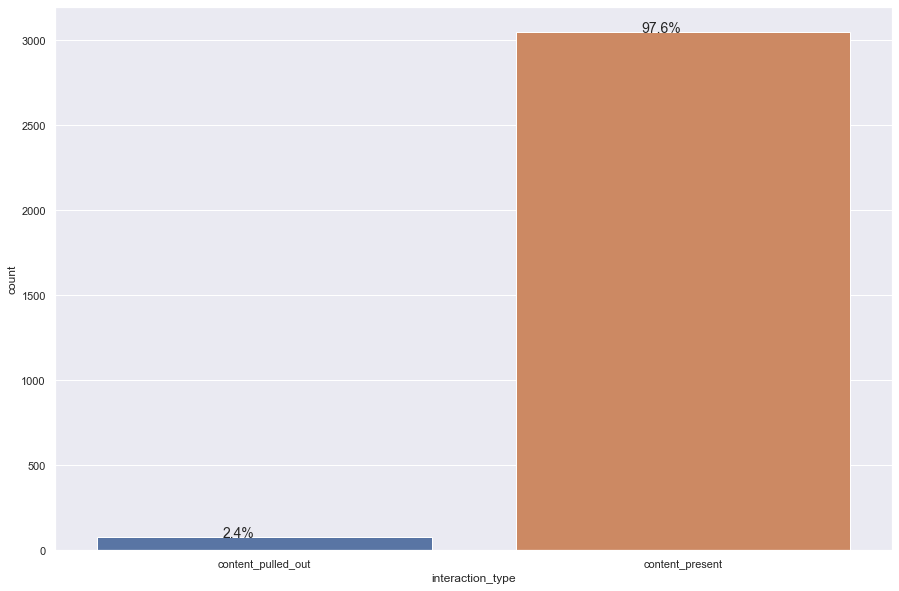

In [29]:
# Checking Distribution of the category Interaction TYpe
perc_on_bar(platform_content["interaction_type"],platform_content)

#### Observation :

- Most common interaction with the platform is content_present.

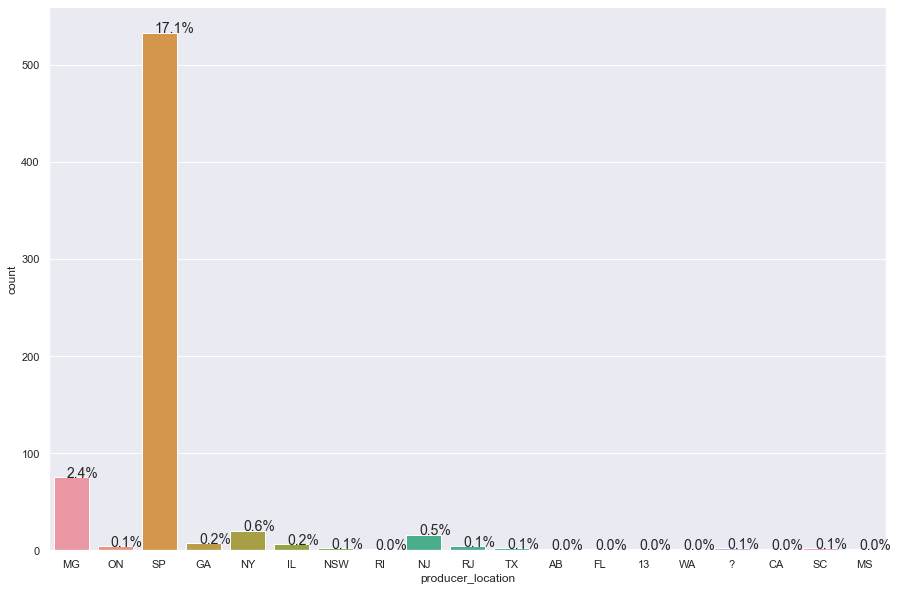

In [30]:
# Checking Distribution of the category Producer Location
perc_on_bar(platform_content["producer_location"],platform_content)

#### Observation :

- '?' is one of the Producer Location which shows data error
- From the previous section we know, that ~78% of data has this as a missing value
- Amoung the locations, SP constitutes a Major chunk compared to it's peers

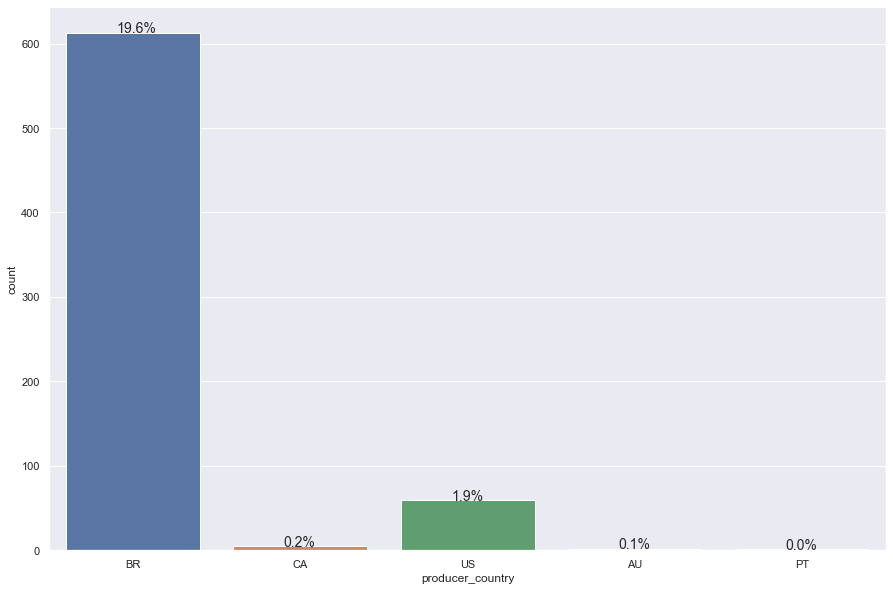

In [31]:
# Checking Distribution of the category Producer Country

perc_on_bar(platform_content["producer_country"],platform_content)

#### Observation :

- From the previous section we know, that ~78% of data has this as a missing value
- Amoung the locations, BR constitutes a Major chunk compared to it's peers, followed by US

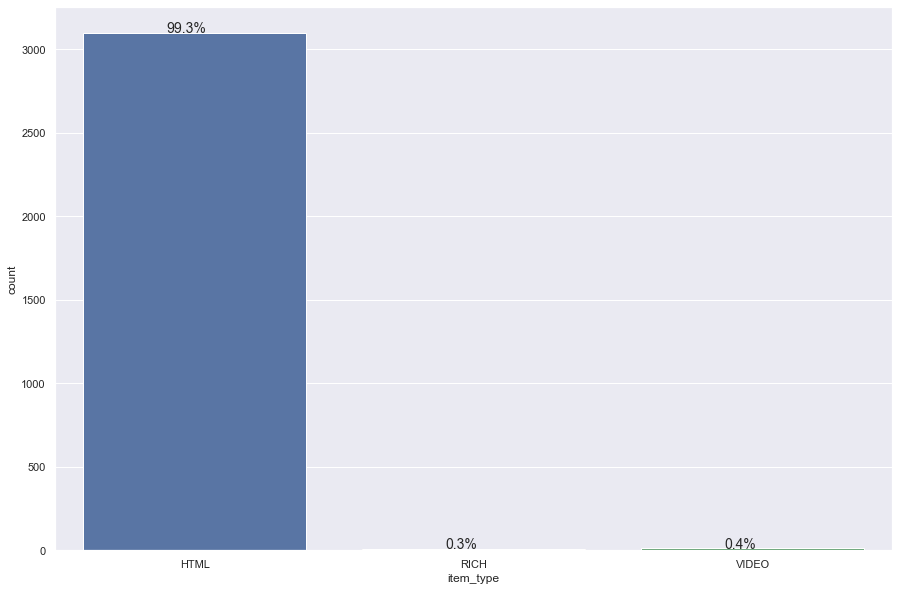

In [32]:
# Checking Distribution of the category Item Type
perc_on_bar(platform_content["item_type"],platform_content)

#### Observation :

- Mostly HTML content is produced by the producers

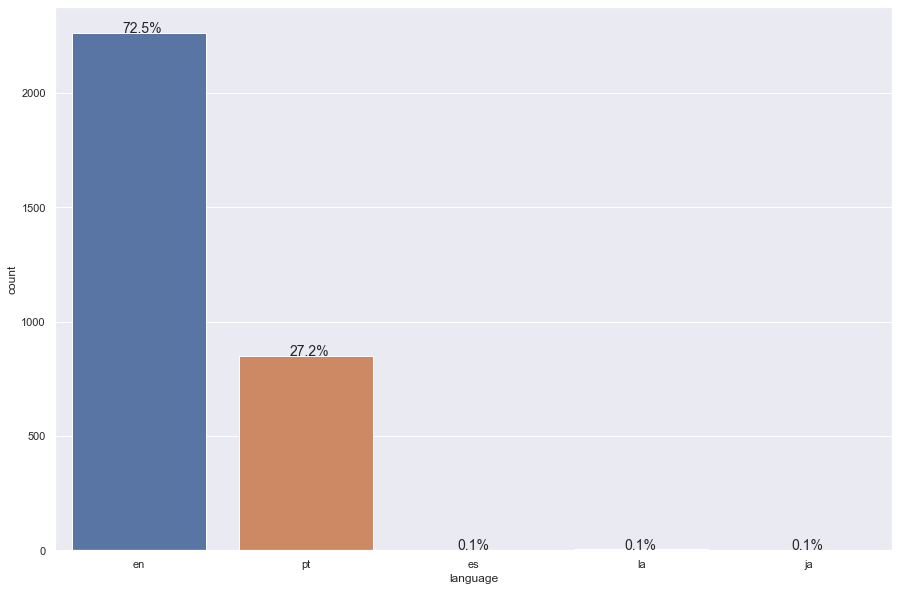

In [33]:
# Checking Distribution of the category Language
perc_on_bar(platform_content["language"],platform_content)

#### Observation :

- English followed by PT are most common choice of producing and item

#### Note :  Since we have lot of unique values for  producer_id & producer_device_info, we would just plot the numbers & not a graph for it

In [34]:
# Checking the Top Producer IDs

pf_content = (platform_content["producer_id"].value_counts(normalize=True)*100).reset_index()
pf_content = pf_content.rename(columns={"index":"producer_id",
                                        "producer_id":"percentage_content"}).sort_values(by='percentage_content',
                                                                                         ascending=False)
pf_content

,producer_id,percentage_content
0,1443636648652872475,9.833440
1,3609194402293569455,9.769379
2,1032019229384696495,8.680333
3,3891637997717104548,4.260090
4,2979881261169775358,2.882767
...,...,...
204,1811781596621121379,0.032031
203,2405211284771043881,0.032031
202,7299489921519728176,0.032031
201,9038446466275805109,0.032031


#### Observation :

1. We can the max content produced by a single producer is ~9.8%
2. One the other end we have producers who have hardly posted content.


In [35]:
# Checking the Top Producer Device
pf_device = (platform_content["producer_device_info"].value_counts(normalize=True)*100).reset_index()
pf_device = pf_device.rename(columns={"index":"producer_device_info",
                                        "producer_device_info":"percentage_content"}).sort_values(by='percentage_content',
                                                                                                  ascending=False)

pf_device

,producer_device_info,percentage_content
0,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,10.441176
1,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,9.558824
2,Android - Native Mobile App,5.147059
3,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,4.264706
4,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,4.117647
...,...,...
84,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,0.147059
85,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_0...,0.147059
86,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1...,0.147059
88,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,0.147059


#### Observation
1. The variance in the Type of Device used by Producers varies a lot.
2. The most common device is used by 10% of the producers

## Exploratory Data Analysis for Consumer Transaction

In [36]:
consumer_trans.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,3499919498720038879,8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,7820640624231356730,445337111692715325,561148 1178424124714,NaN,NaN,NaN


In [37]:
# Checking the Top Consumer Location
ct_loc = consumer_trans["consumer_location"].value_counts(normalize=True).reset_index()
ct_loc = ct_loc.rename(columns={"index":"consumer_location",
                                        "consumer_location":"percentage_content"}).sort_values(by='percentage_content',
                                                                                                  ascending=False)

ct_loc

,consumer_location,percentage_content
0,SP,0.705779
1,MG,0.179767
2,NY,0.022093
3,TX,0.016205
4,GA,0.015994
...,...,...
65,CE,0.000018
64,OR,0.000018
63,ZH,0.000018
62,CL,0.000018


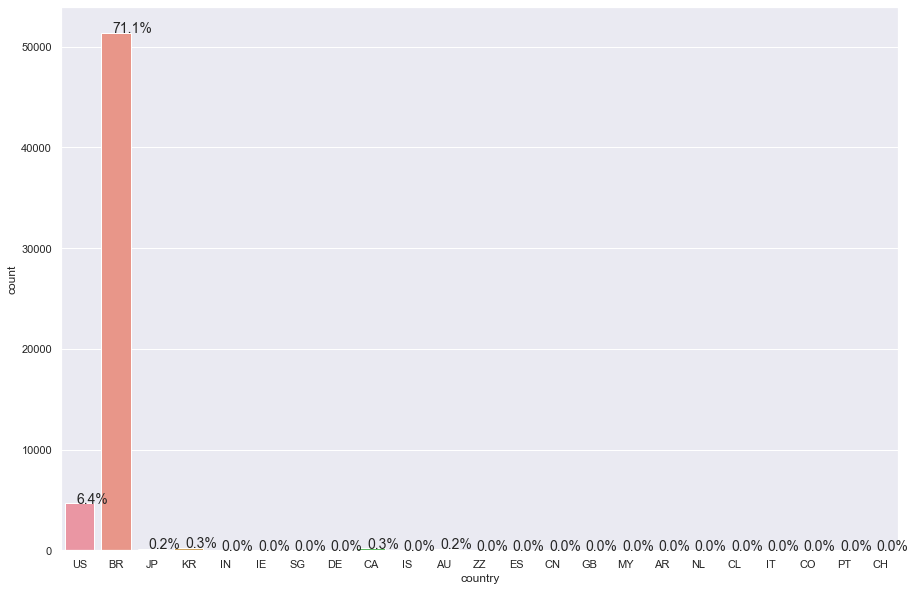

In [38]:
# Checking distribution of Consumer Country
perc_on_bar(consumer_trans["country"],consumer_trans)

#### Observation

- The consumers are mostly from BR & US, which is also reflected in the platform data in terms of Producers

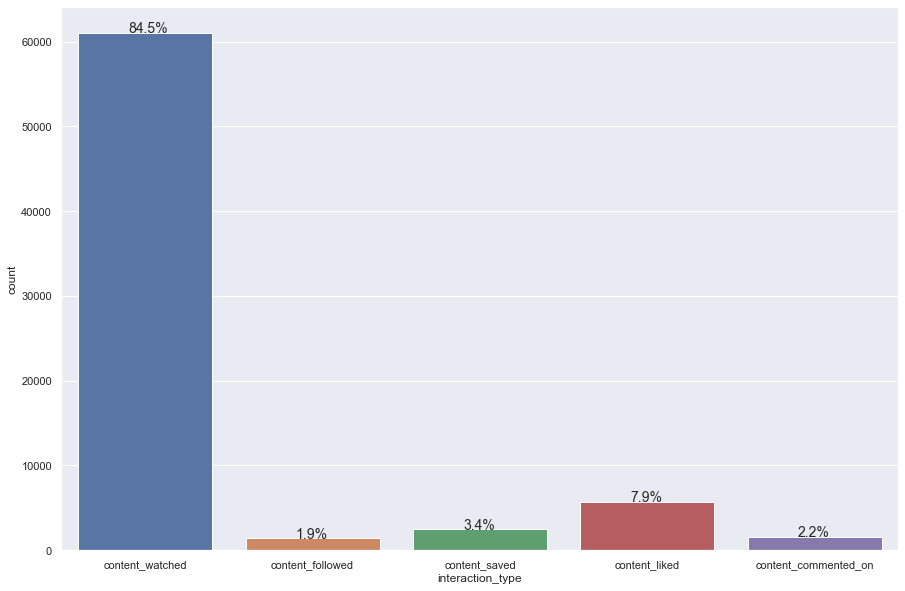

In [39]:
# Checking distribution of Consumer's interaction with the content
perc_on_bar(consumer_trans["interaction_type"],consumer_trans)

#### Observation

- Consumers mostly watch the content and seems to have less engagment wrt to like or commenting on the content
- In terms of interaction liking the content is more common than commenting on it or following it.
- Saving content  shows interest that the user might be willing to revisit the story.

In [40]:
# Checking the Top Consumer Device
ct_dev = consumer_trans["consumer_device_info"].value_counts(normalize=True).reset_index()
ct_dev = ct_dev.rename(columns={"index":"consumer_device_info",
                                        "consumer_device_info":"percentage_content"}).sort_values(by='percentage_content',
                                                                                                  ascending=False)

ct_dev

,consumer_device_info,percentage_content
0,Android - Native Mobile App,0.118632
1,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,0.032035
2,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,0.020138
3,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,0.018908
4,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,0.018609
...,...,...
925,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5...,0.000018
926,Mozilla/5.0 (Linux; Android 6.0.1; D5833 Build...,0.000018
927,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,0.000018
928,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,0.000018


#### Observation

- Consumers mostly seem to use Android mobile devices.
- We should recall that we have missing data for this column as well

## Data Pre-processing

### Creating Ratings

As mentioned and we saw in the datasets, we don't have an explicit rating's column present in the dataset.
We can create this  ratings manually by either of the following ways :

- Giving weightage based on the business priority , like : content_followed (5), followed by content_commented_on (4), content saved(3), content liked(2) and content_watched(1).

- Another approach can be using weightage based on the distribution we observed in the dataset above. We will use this create the weightage for the interaction type to the ratings.

**Note** : We already checked that the **interaction_type** column has no missing values that we need to impute. So we can directly start with the transformations.

In [41]:
consumer_trans['interaction_type'].value_counts(normalize=True)*100

content_watched         84.473244
content_liked            7.945948
content_saved            3.406592
content_commented_on     2.228185
content_followed         1.946031
Name: interaction_type, dtype: float64

**Note** : It can be seen that the order of Magnitude (% of values) in the dataset in inversely related to the weightage priority we have in the business. So, we will inverse the values and scale in a range if 1-5 using Min-Max scaler.

In [42]:
ct_ratings = (consumer_trans['interaction_type'].value_counts(normalize=True)*100).reset_index()
ct_ratings = ct_ratings.rename(columns={"index":"interaction_type","interaction_type":"presence"})
ct_ratings["weightage"] = 100/ct_ratings["presence"]


ct_ratings

,interaction_type,presence,weightage
0,content_watched,84.473244,1.183807
1,content_liked,7.945948,12.585030
2,content_saved,3.406592,29.354852
3,content_commented_on,2.228185,44.879578
4,content_followed,1.946031,51.386638


In [43]:
# Since the weightage for the categories will be static,
# we can fit a Min-Max Scalar to get the weights/ratings on a scale of 1-5.

# These will hence be used consistently for the data

scaler = MinMaxScaler(feature_range=(1, 5))
ct_ratings['ratings'] = scaler.fit_transform(ct_ratings[['weightage']])

# Creating Dictionary
ct_ratings_dict = dict(zip(ct_ratings.interaction_type, ct_ratings.ratings))
print("Ratings Dictionary : {}".format(ct_ratings_dict))


ct_ratings



Ratings Dictionary : {'content_watched': 1.0, 'content_liked': 1.9084127997373104, 'content_saved': 3.244578180344557, 'content_commented_on': 4.481538379529985, 'content_followed': 5.0}


,interaction_type,presence,weightage,ratings
0,content_watched,84.473244,1.183807,1.000000
1,content_liked,7.945948,12.585030,1.908413
2,content_saved,3.406592,29.354852,3.244578
3,content_commented_on,2.228185,44.879578,4.481538
4,content_followed,1.946031,51.386638,5.000000


### Filtering Dataset


In this section, we will be trying to reduce the and filter the dataset based on our requirements only.

- As per the Business problem we are only concerned with Articles in English Language , irrespective the country of origin. So we will remove all other language articles (~27% articles)

- Due to various reasons the content can be pulled out from the platform so we remove the pulled out content and their respective user interactions. (~2.4% of Data)

- Here we are not differentiating b/w producers on the platform. So we remove all details related to producers from the dataset

- Here we are not differentiating b/w consumers based on their demographic or device information. So we are removing those columns

- We could have made models having information about the current session of the User and his behaviour for the current session. But we are not modeling wrt to time or session in this project. So it is safe to remove those features as well.

- Though we will use session to recommend the first 10 entries and later similar entries, so we can keep it in the customer_transaction dataset

In [44]:
# Filter Platform Dataset

print("Platform Dataset Before filtering : {}".format(platform_content.shape))
pc_df= platform_content[(platform_content.language=="en") & (platform_content.interaction_type=="content_present")]

pc_df = pc_df[['item_id','item_url','title','text_description','title_words','title_len','text_words','text_len']]
print("Platform Dataset After filtering : {}".format(pc_df.shape))


pc_df.head()

Platform Dataset Before filtering : (3122, 17)
Platform Dataset After filtering : (2211, 8)


,item_id,item_url,title,text_description,title_words,title_len,text_words,text_len
1,4110354420726924665,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,9,71,1072,6543
2,7292285110016212249,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,11,66,311,1993
3,6151852268067518688,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,5,28,272,1520
4,2448026894306402386,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,9,61,1354,8093
5,2826566343807132236,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,10,64,276,1824


In [45]:
# Filter Platform Dataset

print("Platform Dataset Before filtering : {}".format(consumer_trans.shape))

ct_df = consumer_trans[['interaction_type','item_id','consumer_id']]
# populate the ratings column
ct_df['ratings'] = consumer_trans['interaction_type'].map(ct_ratings_dict)
ct_df = ct_df[['item_id','consumer_id','ratings']]

# Remove Duplicates if Any for Consumer & Article rating; take the Max rating
ct_df = ct_df.loc[ct_df.groupby(["consumer_id","item_id"])['ratings'].idxmax()]

# ct_df = ct_df[~ct_df.consumer_id.isin([8516196196975927])]
ct_df.reset_index(inplace=True)
ct_df.pop('index')
# Filter only English Articles & those present in the platform
# ct_df = pd.merge(ct_df,pc_df[["item_id"]],left_on="item_id",right_on="item_id",how="inner")

print("Platform Dataset After filtering : {}".format(ct_df.shape))


ct_df.head()

Platform Dataset Before filtering : (72301, 8)
Platform Dataset After filtering : (40710, 3)


,item_id,consumer_id,ratings
0,2171751753892441512,8516196196975927,1.0
1,2607211459879791691,9503309754973814,1.0
2,4029704725707465084,9503309754973814,1.0
3,2267321579404324900,13723062087756322,1.0
4,4233809085822159066,13723062087756322,1.0


#### Creating Lookup for item_ids & consumer_id

Since item_id & consumer_ids are large intergers, for sake of simplicity, creating a lookup dictionary for easy mapping.

In [46]:
# Creating Item/News Lookup Dict
ct_items = ct_df['item_id'].tolist()
pc_items = pc_df['item_id'].tolist()

# Creating Lookup  & Reverse Lookup for Item IDs
items = list(set(ct_items))
items_dict = {k: idx for idx, k in enumerate(items)}           # Format : {item_id:idx}
inverse_items_dict = {idx: k for idx, k in enumerate(items)}   # Format : {idx:item_id}


# Creating Lookup & Reverse Lookup for Consumer IDs
ct_users = ct_df['consumer_id'].tolist()
ct_users.extend(ct_users) #Master List of Items

users = list(set(ct_users))
users_dict = {k: idx for idx, k in enumerate(users)}           # Format : {consumer_id:idx}
inverse_users_dict = {idx: k for idx, k in enumerate(users)}   # Format : {idx:consumer_id}


print("Item Dictionary Length : {}".format(len(items_dict)))
print("Consumer Dictionary Length : {}".format(len(users_dict)))


n_users = ct_df.consumer_id.nunique()
n_items = ct_df.item_id.nunique()

print("Number of Unique Users : {}".format(n_users))
print("Number of Unique Items : {}".format(n_items))


# Map the Dataframe accordingly 

ct_df['consumer_id'] = ct_df['consumer_id'].map(users_dict)
ct_df['item_id'] = ct_df['item_id'].map(items_dict)

Item Dictionary Length : 2987
Consumer Dictionary Length : 1895
Number of Unique Users : 1895
Number of Unique Items : 2987


In [47]:
ct_df

,item_id,consumer_id,ratings
0,1251,309,1.000000
1,1119,1805,1.000000
2,144,1805,1.000000
3,1507,582,1.000000
4,812,582,1.000000
...,...,...,...
40705,2145,396,1.908413
40706,2209,396,1.000000
40707,989,396,1.000000
40708,2763,396,1.000000


## Building Recommendation System


Now,that we have prepared the raw dataset with the ratings, we will try to build different type of Recommendation Systems & Evaluate them accordingly.

The Major focus will be to build the following :

1. User-based Collaborative Filtering (User-User) System
2. Item-based Collaborative Filtering (User-Item) System
3. Content-based Recommendation : for recommending similar items to what user has already watched.
4. ALS Recommendation System
5. Hybrid Recommendation System from the above.

In [48]:
# Create Splits

# Test and Train split of the dataset.
train, test = train_test_split(ct_df, test_size=0.20, random_state=42)

print("Training Dataset Shape. : {} ".format(train.shape))
print("Test Dataset Shape. : {} ".format(test.shape))

Training Dataset Shape. : (32568, 3) 
Test Dataset Shape. : (8142, 3) 


#### Creating dummy train & dummy test dataset

These dataset will be used for prediction 
- Dummy train will be used later for prediction of the News Articles which has not been viewed/rated by the consumer. To ignore the News seen/rated by the consumer, we will mark it as 0 during prediction. The News Articles not seen/rated by consumer is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the News seen/rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

## 1. User Based Collaborative Recommendation System

In [49]:
# Pivot the train ratings' dataset into matrix format in which columns are News ID and the rows are Consumer IDs.
# Here, we are not removing the NaN values and calculating the mean only for the News rated by the user

# Populate User-News Rating for Train Set
train_pivot = np.zeros((n_users, n_items))
for line in train.itertuples():
    train_pivot[line[2]-1,line[1]-1 ] = line[3]

# Populate User-News Ratings for Test Set   
test_pivot = np.zeros((n_users, n_items))
for line in test.itertuples():
    test_pivot[line[2]-1, line[1]-1] = line[3]
    

# Populate User-News Ratings for Whole DataSet   
data_pivot = np.zeros((n_users, n_items))
for line in ct_df.itertuples():
    data_pivot[line[2]-1,line[1]-1 ] = line[3]
    
    
    
# Normalising the rating of the movie for each user around 0 mean
mean = np.nanmean(train_pivot, axis=1)
train_subtracted = pd.DataFrame((train_pivot.T-mean).T) #pd.DataFrame(train_pivot)

print("Train Subtracted : {}".format(train_subtracted.shape))
train_subtracted.head(3)

Train Subtracted : (1895, 2987)


,0,1,2,3,4,5,6,7,8,9,...,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986
0,-0.000639,-0.000639,-0.000639,-0.000639,-0.000639,-0.000639,-0.000639,-0.000639,-0.000639,-0.000639,...,-0.000639,-0.000639,-0.000639,-0.000639,-0.000639,-0.000639,-0.000639,-0.000639,-0.000639,-0.000639
1,-0.001674,-0.001674,-0.001674,-0.001674,-0.001674,-0.001674,-0.001674,-0.001674,-0.001674,-0.001674,...,-0.001674,-0.001674,-0.001674,-0.001674,-0.001674,-0.001674,-0.001674,-0.001674,-0.001674,-0.001674
2,-0.005104,-0.005104,-0.005104,-0.005104,-0.005104,-0.005104,-0.005104,-0.005104,-0.005104,-0.005104,...,-0.005104,-0.005104,-0.005104,-0.005104,-0.005104,-0.005104,-0.005104,-0.005104,-0.005104,-0.005104


#### Finding cosine similarity(adjusted cosine here)

- User Similarity Matrix

**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case] 

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different movies

In [50]:
# Creating the User Similarity Matrix using pairwise_distance function.

user_correlation = 1 - pairwise_distances(train_subtracted, metric='cosine')
print("User-User/ Consumer-Consumer Matrix Shape: {}".format(user_correlation.shape))
print(user_correlation)

User-User/ Consumer-Consumer Matrix Shape: (1895, 1895)
[[ 1.00000000e+00 -7.49352708e-04 -7.83459746e-04 ... -9.80238987e-04
  -1.68118168e-03 -1.19156168e-03]
 [-7.49352708e-04  1.00000000e+00 -1.75304382e-03 ... -2.19335059e-03
  -3.76175697e-03 -2.66619930e-03]
 [-7.83459746e-04 -1.75304382e-03  1.00000000e+00 ... -2.29318167e-03
  -3.93297459e-03 -2.78755225e-03]
 ...
 [-9.80238987e-04 -2.19335059e-03 -2.29318167e-03 ...  1.00000000e+00
   8.02015738e-03 -3.48769341e-03]
 [-1.68118168e-03 -3.76175697e-03 -3.93297459e-03 ...  8.02015738e-03
   1.00000000e+00  1.49722011e-02]
 [-1.19156168e-03 -2.66619930e-03 -2.78755225e-03 ... -3.48769341e-03
   1.49722011e-02  1.00000000e+00]]


#### Prediction - User Based (User-Item Matrix)

Doing the prediction for the consumers which are positively related with other consumers, and not the consumers which are negatively related as we are interested in the consumers which are more similar to the current consumers. So, ignoring the correlation for values less than 0. 

In [51]:
user_correlation[user_correlation<0]=0
print("Positively Corelated Consumers Size : {}".format(user_correlation.shape))

# predictions on the Train Set
user_predicted_ratings_train = np.dot(user_correlation, train_pivot)
print("Predictions of Train Set Size : {}".format(user_predicted_ratings_train.shape))


# predictions on the Test Set
user_predicted_ratings_test = np.dot(user_correlation, test_pivot)
print("Predictions of Test Set Size : {}".format(user_predicted_ratings_test.shape))

# predictions on the Test Set
user_predicted_ratings_data = np.dot(user_correlation, data_pivot)
print("Predictions of Whole Set Size : {}".format(user_predicted_ratings_data.shape))



Positively Corelated Consumers Size : (1895, 1895)
Predictions of Train Set Size : (1895, 2987)
Predictions of Test Set Size : (1895, 2987)
Predictions of Whole Set Size : (1895, 2987)


In [52]:
# Creating Dummy Dataframes to filtering existing Ratings aka news already seen by User

# Custom Fuction to mask already rated content as 0 for prediction
def create_pred_mask(elem) :
    
    # elem is the rating for the User-Item pair from consumer transactions 
    if elem>=1 :
        return 0
    else :
        return 1

In [53]:
# Create Pred Dummy 

train_pred_dummy = pd.DataFrame(train_pivot)
train_pred_dummy = train_pred_dummy.applymap(create_pred_mask)

test_pred_dummy = pd.DataFrame(test_pivot)
test_pred_dummy = test_pred_dummy.applymap(create_pred_mask)

data_pred_dummy = pd.DataFrame(data_pivot)
data_pred_dummy = data_pred_dummy.applymap(create_pred_mask)

train_pred_dummy.head()

,0,1,2,3,4,5,6,7,8,9,...,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


#### User Based Predictions

Finally, we multiply the user_predicted_ratings_* arrays to the mask to filter out already rated content. Via this when we recommend Top N recommendations it will always exlcude already rated content.

It should be noted that for evaluation we will be treating Train & test separately. Final recommendation will be done over the complete dataset to give the best recommendation.

In [54]:
# Final Train Set Predictions
user_rating_train = np.multiply(user_predicted_ratings_train,train_pred_dummy)

# Final Test Set Predictions
user_rating_test = np.multiply(user_predicted_ratings_test,test_pred_dummy)

# Final Whole Set Predictions
user_rating_data = np.multiply(user_predicted_ratings_data,data_pred_dummy)

## 2. Item Based Collaborative Recommendation System

In Item Based system, the process remains same as the User Based system, apart from the difference that we compute item_correleations. This is achieved by transposing the metrics operations we performed earlier in the User Based Recommendation System

In [55]:
# Transposing the Datasets from the User based System
train_item_pivot = train_pivot.T
test_item_pivot = test_pivot.T
data_item_pivot = data_pivot.T

print("Training Item based Size : {}".format(train_item_pivot.shape))
print("Test Item based Size : {}".format(test_item_pivot.shape))
print("Dataset Item based Size : {}".format(data_item_pivot.shape))


# Normalising the rating of the movie for each user around 0 mean
mean = np.nanmean(train_item_pivot, axis=1)
train_item_subtracted = pd.DataFrame((train_item_pivot.T-mean).T)
# train_item_subtracted = pd.DataFrame(train_item_pivot)

print("Train Subtracted : {}".format(train_item_subtracted.shape))
train_item_subtracted.head(3)

Training Item based Size : (2987, 1895)
Test Item based Size : (2987, 1895)
Dataset Item based Size : (2987, 1895)
Train Subtracted : (2987, 1895)


,0,1,2,3,4,5,6,7,8,9,...,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894
0,-0.015324,-0.015324,-0.015324,-0.015324,-0.015324,-0.015324,-0.015324,-0.015324,-0.015324,-0.015324,...,-0.015324,-0.015324,-0.015324,-0.015324,-0.015324,-0.015324,-0.015324,-0.015324,-0.015324,-0.015324
1,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,...,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701
2,-0.000528,-0.000528,-0.000528,-0.000528,-0.000528,-0.000528,-0.000528,-0.000528,-0.000528,-0.000528,...,-0.000528,-0.000528,-0.000528,-0.000528,-0.000528,-0.000528,-0.000528,-0.000528,-0.000528,-0.000528


In [56]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_item_subtracted, metric='cosine')
# item_correlation[np.isnan(item_correlation)] = 0
print("Item-Item/ News-News Matrix Shape: {}".format(item_correlation.shape))
print(item_correlation)

Item-Item/ News-News Matrix Shape: (2987, 2987)
[[ 1.          0.03205018 -0.00185238 ...  0.08549504 -0.00435832
  -0.00643746]
 [ 0.03205018  1.         -0.00144427 ... -0.01004819  0.10123505
   0.06703969]
 [-0.00185238 -0.00144427  1.         ... -0.00367332 -0.00124225
  -0.00183487]
 ...
 [ 0.08549504 -0.01004819 -0.00367332 ...  1.         -0.00864266
   0.00537751]
 [-0.00435832  0.10123505 -0.00124225 ... -0.00864266  1.
  -0.00431711]
 [-0.00643746  0.06703969 -0.00183487 ...  0.00537751 -0.00431711
   1.        ]]


#### Prediction - Item Based (Item-Item Matrix)

Doing the prediction for the News which are positively related with other News, and not the News which are negatively related as we are interested in the consumers which are more similar to the current consumers. So, ignoring the correlation for values less than 0. 

In [57]:
item_correlation[item_correlation<0]=0
item_correlation_df = pd.DataFrame(item_correlation) # to be used in Hybdrid Recommendation System


# predictions on the Train Set
item_predicted_ratings_train = np.dot(train_item_pivot.T, item_correlation )
print("Predictions of Train Set Size : {}".format(item_predicted_ratings_train.shape))


# predictions on the Test Set
item_predicted_ratings_test = np.dot(train_item_pivot.T, item_correlation)
print("Predictions of Test Set Size : {}".format(item_predicted_ratings_test.shape))

# predictions on the Test Set
item_predicted_ratings_data = np.dot(train_item_pivot.T, item_correlation)
print("Predictions of Whole Set Size : {}".format(item_predicted_ratings_data.shape))


Predictions of Train Set Size : (1895, 2987)
Predictions of Test Set Size : (1895, 2987)
Predictions of Whole Set Size : (1895, 2987)


#### Item Based Predictions 

Finally, we multiply the user_predicted_ratings_* arrays to the mask to filter out already rated content. Via this when we recommend Top N recommendations it will always exlcude already rated content.

In [58]:
# Final Train Set Predictions
item_rating_train = np.multiply(item_predicted_ratings_train,train_pred_dummy)

# Final Test Set Predictions
item_rating_test = np.multiply(item_predicted_ratings_test,test_pred_dummy)

# Final Whole Set Predictions
item_rating_data = np.multiply(item_predicted_ratings_data,data_pred_dummy)

## 3. Content Based Recommendation

This solves our second problem statement where we want to recommend similar News Articles based on what the Consumer has read in the morning. For this we would be trying to find similarity between the  News Content on the Platform using the text in the Title & Text Description.


Key Strategies :

- While using content based filtering or NLP problem, it's a general practice to remove stop-words and do stemming & lemmatisation. 
- In the first version of the Recommendation, I don't do these for the following reasons :
    - TF-IDF based on it's formulation already give poor scoring to most commonly occuring words (like stop-words)
    - Explicit Cleaning is not required as News Articles are authored with great care to avoid spell errors or grammatical mistakes.
    - Stemming or Lemmatizing could have helped to reduce words to their base form for similarity, but I plan to do this later in more advanced versions.

In [59]:
# Split Text into words & create a Document/New Wordlist column

pc_df['title_wordlist'] = pc_df['title'].apply(lambda x : str.lower(x).split()) 
pc_df['text_wordlist'] = pc_df['text_description'].apply(lambda x : str.lower(x).split()) 
pc_df['document_wordlist'] = pc_df.apply(lambda row : row['title_wordlist']+ row['text_wordlist'],axis=1)

pc_df.head(2)

,item_id,item_url,title,text_description,title_words,title_len,text_words,text_len,title_wordlist,text_wordlist,document_wordlist
1,4110354420726924665,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,9,71,1072,6543,"[ethereum,, a, virtual, currency,, enables, tr...","[all, of, this, work, is, still, very, early.,...","[ethereum,, a, virtual, currency,, enables, tr..."
2,7292285110016212249,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,11,66,311,1993,"[bitcoin, future:, when, gbpcoin, of, branson,...","[the, alarm, clock, wakes, me, at, 8:00, with,...","[bitcoin, future:, when, gbpcoin, of, branson,..."


In [60]:
# Creating the Document Wordlist
wordlist = pc_df['document_wordlist'].tolist()
print("Length of WordList : {}".format(len(wordlist)))

# Creating the dictionary for the News Article
dictionary = Dictionary(wordlist) 
print("Length of Dictionary : {}".format(len(dictionary)))

### Generate Corpus by creating BOW of each document
corpus = [dictionary.doc2bow(doc) for doc in wordlist] 
print("Length of Corpus : {}".format(len(corpus)))

# Create TF-IDF model
tfidf = TfidfModel(corpus)

## Generate Similarity Matrix
sims = MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))
print(sims)

Length of WordList : 2211
Length of Dictionary : 113750
Length of Corpus : 2211
MatrixSimilarity<2211 docs, 113750 features>


In [61]:
def content_recommendation(item_id,number_of_hits=10):
    # get the movie row
    news = pc_df.loc[pc_df.item_id==item_id] 
    
    #set the list of words to query_doc
    query_doc = news['document_wordlist'].iloc[0] 
    
    # get a bag of words from the query_doc
    query_doc_bow = dictionary.doc2bow(query_doc) 

    #convert the regular bag of words model to a tf-idf model
    query_doc_tfidf = tfidf[query_doc_bow] 

    # get similarity values between input movie and all other movies
    similarity_array = sims[query_doc_tfidf] 

    #Convert to a Series
    similarity_series = pd.Series(similarity_array.tolist(), index=pc_df.item_id.values) 
    similarity_df = pd.DataFrame(similarity_series).reset_index().rename(columns={'index':'item_id',0:'score'})
    similarity_df = pd.merge(similarity_df,pc_df[['item_id','title']],left_on="item_id",right_on="item_id",how="inner")
    

    #get the most similar movies except the first which will be the same movie
    similarity_output = similarity_df.sort_values(by="score",ascending=False)[1:number_of_hits+1] 
    return similarity_output

In [62]:
content_pred = content_recommendation(4110354420726924665)
content_pred

,item_id,score,title
8,3353902017498793780,0.699051,The Rise And Growth of Ethereum Gets Mainstrea...
424,1485652648052127324,0.454741,"For Blockchain VCs, the Time for Ethereum Inve..."
157,5274322067107287523,0.432198,Ethereum and Bitcoin Are Market Leaders But No...
94,6713697716910928909,0.387480,Solidity Available in Visual Studio - Ethereum...
71,3067875254349597654,0.345733,Microsoft Adds Ethereum to Windows Platform Fo...
160,8084284001249507595,0.316481,Microsoft Continues to Embrace Ethereum & Bitc...
101,9171475473795142532,0.292799,Decentralized Options Exchange Etheropt Uses A...
97,4849766494522371290,0.267386,Cashila Announces Convenient Buy and Sell Feat...
112,2711301039947937868,0.230289,"Eyeing Volume, Asian Exchanges Add Support for..."
158,4917007328809735647,0.216469,"Google Failure, Ethereum Leaps, ECB Giveout in..."


### 4. ALS Model for Recommendation

While we train an ALS system, it's important to point out that we can use this system to get two kind of Recommendations as follows :

1. Based on User ID , we can get best recommendations for them
2. Based on Item ID, we can get similar News Article. We can use this in a complementing way with Content based recommendation to recommend similar items.

In [63]:
# ! pip install implicit

In [64]:
### Create Consumer Sparse Matrix
alpha = 40
sparse_user_item = csr_matrix( ([alpha]*ct_df.shape[0], (ct_df['consumer_id'], ct_df['item_id']) ))
# convert to array
csr_user_array = sparse_user_item.toarray()

print("User-Item Sparse Matrix : {}".format(sparse_user_item.shape))


### Create item-user sparse matrix
sparse_item_user = sparse_user_item.T.tocsr()
print("Item-User Sparse Matrix : {}".format(sparse_item_user.shape))

User-Item Sparse Matrix : (1895, 2987)
Item-User Sparse Matrix : (2987, 1895)


In [65]:
## Create train, test data
train, test = evaluation.train_test_split(sparse_item_user, train_percentage=0.8)
als_model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.1, 
                                             iterations=20, calculate_training_loss=False)


print("Training Set Size :")
# train the model
als_model.fit(train)

Training Set Size :


In [66]:
# Sample RUn for prediction
user_id=10
item_id=10

In [67]:
# Sample Run to Recommend Based on User
output = als_model.recommend(user_id, sparse_user_item)
output_df = pd.DataFrame(output, columns=['item_id', 'als_score'])
output_df.head()

,item_id,als_score
0,2743,0.525171
1,282,0.468386
2,1328,0.465543
3,739,0.462319
4,823,0.428877


In [68]:
# Sample Run to Recommend Similar Item
n_similar = 10
similar = als_model.similar_items(item_id, n_similar)
similar_df = pd.DataFrame(similar, columns=['item_id', 'als_scoreout;'])

In [69]:
similar_df

,item_id,als_scoreout;
0,10,1.000000
1,1618,0.814410
2,2157,0.577986
3,834,0.537547
4,2735,0.473565
5,2581,0.471452
6,2246,0.451982
7,228,0.448315
8,2123,0.448315
9,2802,0.448315


### 5. Hybrid Recommendation System

Based on the above evaluation we will be creating the following Hybrid Recommendations :

1. Item-Item Recommendation + Content Based Recommendation : Normalising the Scores of Each & Giving Equal Weightage
2. ALS Similar Item Recommendation + Content Based Recommendation : Normalising the Scores of Each & Giving Equal Weightage
3. ALS Similar Item Recommendation + Item Based Recommendation : Normalising the Scores of Each & Giving Equal Weightage
4. ALS User-Item Recommendation + User-User Collaborative Recommendations : Equal Weightage to both



In [70]:
def hybrid_item_content(item_id,topn=10) :
    
    # prepare Content Based Recommendation
    content_pred = content_recommendation(item_id,number_of_hits=2000) # It already removed the same ID
    min_content,max_content = min(content_pred['score']),max(content_pred['score'])
    denom_content = max_content - min_content
    content_pred["normalized_content_score"] = (content_pred['score']-min_content)/denom_content
    
    # prepare Item based Collaborative Recommendation
    inverse_item_id = items_dict[item_id]
    # Remove the Same ID by starting from 1
    item_pred = item_correlation_df.iloc[inverse_item_id][1:].reset_index()
    item_pred  = item_pred.rename(columns={"index":"item_id",
                                           inverse_item_id:"score"}).sort_values(by="score",ascending=False)
    
    min_item,max_item = min(item_pred['score']),max(item_pred['score'])
    denom_item = max_item - min_item
    item_pred['item_id'] = item_pred['item_id'].map(inverse_items_dict)
    item_pred["normalized_colab_score"] = (item_pred['score']-min_item)/denom_item
    
    # Merge the Results & Normalise
    hybrid_pred=pd.merge(item_pred[["item_id","normalized_colab_score"]],
                         content_pred[["item_id","title","normalized_content_score"]],how="left")
    hybrid_pred["final_score"] = (hybrid_pred["normalized_colab_score"] + 
                                  hybrid_pred["normalized_content_score"])/2
    
    hybrid_pred.sort_values(by="final_score",ascending=False,inplace=True)
    # Send Top N
    hybrid_pred = hybrid_pred.reset_index(drop=True).iloc[:topn][['item_id','title','final_score']]
    
    
    return hybrid_pred

In [71]:
def hybrid_als_content(item_id,topn=10) :
    
    # prepare Content Based Recommendation
    content_pred = content_recommendation(item_id,number_of_hits=2000) # It already removed the same ID
    min_content,max_content = min(content_pred['score']),max(content_pred['score'])
    denom_content = max_content - min_content
    content_pred["normalized_content_score"] = (content_pred['score']-min_content)/denom_content
    
    # prepare Item based Collaborative Recommendation
    inverse_item_id = items_dict[item_id]
    # Remove the Same ID by starting from 1
    als_similar = als_model.similar_items(inverse_item_id, 2000)
    als_pred = pd.DataFrame(als_similar, columns=['item_id', 'score'])
    
    
    min_als,max_als = min(als_pred['score']),max(als_pred['score'])
    denom_als =  max_als - min_als
    als_pred['item_id'] = als_pred['item_id'].map(inverse_items_dict)
    als_pred["normalized_als_score"] = (als_pred['score']-min_als)/denom_als
    
    # Merge the Results & Normalise
    hybrid_pred=pd.merge(als_pred[["item_id","normalized_als_score"]],
                         content_pred[["item_id","title","normalized_content_score"]],how="left")
    hybrid_pred["final_score"] = (hybrid_pred["normalized_als_score"] + 
                                  hybrid_pred["normalized_content_score"])/2
    
    hybrid_pred.sort_values(by="final_score",ascending=False,inplace=True)
    # Send Top N
    hybrid_pred = hybrid_pred.reset_index(drop=True).iloc[:topn][['item_id','title','final_score']]
    
    
    return hybrid_pred

In [72]:
def hybrid_als_item(item_id,topn=10) :
    
    
    # prepare Item based Collaborative Recommendation
    inverse_item_id = items_dict[item_id]
    # Remove the Same ID by starting from 1
    als_similar = als_model.similar_items(inverse_item_id, 2000)
    als_pred = pd.DataFrame(als_similar, columns=['item_id', 'score'])
    
    min_als,max_als = min(als_pred['score']),max(als_pred['score'])
    denom_als =  max_als - min_als
    als_pred['item_id'] = als_pred['item_id'].map(inverse_items_dict)
    als_pred["normalized_als_score"] = (als_pred['score']-min_als)/denom_als
    
    
    # prepare Item based Collaborative Recommendation
 
    # Remove the Same ID by starting from 1
    item_pred = item_correlation_df.iloc[inverse_item_id][1:].reset_index()
    item_pred  = item_pred.rename(columns={"index":"item_id",
                                           inverse_item_id:"score"}).sort_values(by="score",ascending=False)
    
    min_item,max_item = min(item_pred['score']),max(item_pred['score'])
    denom_item = max_item - min_item
    item_pred['item_id'] = item_pred['item_id'].map(inverse_items_dict)
    item_pred["normalized_item_score"] = (item_pred['score']-min_item)/denom_item
    
    # Merge the Results & Normalise
    hybrid_pred=pd.merge(als_pred[["item_id","normalized_als_score"]],
                         item_pred[["item_id","normalized_item_score"]],how="left")
    hybrid_pred["final_score"] = (hybrid_pred["normalized_als_score"] + 
                                  hybrid_pred["normalized_item_score"])/2
    
    
    # Merging to get the Titles
    hybrid_pred = pd.merge(hybrid_pred,pc_df[['item_id','title']],how="left").sort_values(by="final_score",
                                                                                          ascending=False)
    # Send Top N
    hybrid_pred = hybrid_pred.reset_index(drop=True).iloc[:topn][['item_id','title','final_score']]
    
    
    return hybrid_pred

In [73]:
def hybrid_als_user(inverse_user_id,topn=10) :
    
    #converting User ID to the lookup value
    user_id = users_dict[inverse_user_id]
    
    als_pred = als_model.recommend(user_id, sparse_user_item)
    als_pred = pd.DataFrame(als_pred, columns=['item_id', 'score'])
    
    min_als,max_als = min(als_pred['score']),max(als_pred['score'])
    denom_als = max_als - min_als

    als_pred["normalized_als_score"] = (als_pred['score']-min_als)/denom_als
    
    
    colab_user_df = pd.DataFrame(user_predicted_ratings_test).iloc[user_id]
    colab_pred = colab_user_df.reset_index().rename(columns={"index":"item_id",
                                                           user_id:"score"}).sort_values(by="score",
                                                                                         ascending=False)
    
    min_user,max_user = min(colab_pred['score']),max(colab_pred['score'])
    denom_user = max_user - min_user
    colab_pred["normalized_colab_score"] = (colab_pred['score']-min_user)/denom_user
    
    
    # Merge the Results & Normalise
    hybrid_pred=pd.merge(als_pred[["item_id","normalized_als_score"]],
                         colab_pred[["item_id","normalized_colab_score"]],how="left")
    hybrid_pred["final_score"] = (hybrid_pred["normalized_als_score"] + 
                                  hybrid_pred["normalized_colab_score"])/2
    
    hybrid_pred.sort_values(by="final_score",ascending=False,inplace=True)
    # Converting the  Item ID back to Original Values
    hybrid_pred['item_id'] = hybrid_pred['item_id'].map(inverse_items_dict)
    # Merging to get the Titles
    hybrid_pred = pd.merge(hybrid_pred,pc_df[['item_id','title']],how="left").sort_values(by="final_score",
                                                                                          ascending=False)
    
    # Send Top N
    hybrid_pred = hybrid_pred.reset_index(drop=True).iloc[:topn][['item_id','title','final_score']]
    
    
    return hybrid_pred
    

#### Testing Hybrid Recommendations 

Here I take a Sample News Article and see the results from Different Hybrid Systems as Defined Earlier.

In [74]:
# Test News Articl;e
pc_df[pc_df.item_id==4110354420726924665]

,item_id,item_url,title,text_description,title_words,title_len,text_words,text_len,title_wordlist,text_wordlist,document_wordlist
1,4110354420726924665,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,9,71,1072,6543,"[ethereum,, a, virtual, currency,, enables, tr...","[all, of, this, work, is, still, very, early.,...","[ethereum,, a, virtual, currency,, enables, tr..."


In [75]:
# Results from Collaborative Item Based Recommendation & Content Based Recommendations
hybrid_item_content(4110354420726924665)

,item_id,title,final_score
0,3353902017498793780,The Rise And Growth of Ethereum Gets Mainstrea...,0.500000
1,1485652648052127324,"For Blockchain VCs, the Time for Ethereum Inve...",0.323304
2,7900768082301348135,"Band plays on, as global oil glut leaves super...",0.321340
3,5289386635926629588,Punch-Drunk Love (2002),0.319660
4,5274322067107287523,Ethereum and Bitcoin Are Market Leaders But No...,0.318453
5,4138575697540914268,Spotify's Latest Algorithmic Playlist Is Full ...,0.314743
6,7277691357631151609,Giant-Man Goes Down in CAPTAIN AMERICA: CIVIL ...,0.314223
7,5784228041033890044,[E-learning] Design Thinking for Innovation - ...,0.310259
8,2871288807409592,"Dilma Rousseff's Impeachment Isn't a Coup, It'...",0.308245
9,1920899299418335515,AI Revolution 101 - AI Revolution,0.299695


In [76]:
# Results from ALS Similar Items & Content Based Recommendations
hybrid_als_content(4110354420726924665)

,item_id,title,final_score
0,8084284001249507595,Microsoft Continues to Embrace Ethereum & Bitc...,0.536257
1,8445686000003509032,"Proof of Individuality, the New-Age Security o...",0.531985
2,4917007328809735647,"Google Failure, Ethereum Leaps, ECB Giveout in...",0.447544
3,1586004000405879970,Gold Backed Digix Raises Millions in Hours on ...,0.423479
4,1485652648052127324,"For Blockchain VCs, the Time for Ethereum Inve...",0.357684
5,9171475473795142532,Decentralized Options Exchange Etheropt Uses A...,0.346556
6,5145921881592486583,Open Source Giant Red Hat Launches First Block...,0.335271
7,5274322067107287523,Ethereum and Bitcoin Are Market Leaders But No...,0.333674
8,4228415104574264137,Up your app's sharing game with DirectShare - ...,0.330490
9,3067875254349597654,Microsoft Adds Ethereum to Windows Platform Fo...,0.323064


In [77]:
# Results from ALS Similar Items & Collaborative Item Based Recommendation 
hybrid_als_item(4110354420726924665)

,item_id,title,final_score
0,4110354420726924665,"Ethereum, a Virtual Currency, Enables Transact...",1.000000
1,8445686000003509032,"Proof of Individuality, the New-Age Security o...",0.500000
2,2518704978033827255,Google Now Posting Full OTA Images For Nexus D...,0.374183
3,7481609677042800346,NaN,0.368509
4,3173020603774823976,Welcome Google Cloud Platform!,0.356507
5,2871288807409592,"Dilma Rousseff's Impeachment Isn't a Coup, It'...",0.347021
6,8031358134051918098,Learn Microservices in Java - DZone - Refcardz,0.344706
7,7277691357631151609,Giant-Man Goes Down in CAPTAIN AMERICA: CIVIL ...,0.342683
8,4562218760600603086,Performance Testing in a Nutshell,0.341398
9,273156842634169039,4K movies come to the Google Play Movies & TV app,0.333032


In [78]:
# Testing Hybrid User based Recommendation
hybrid_als_user(4142810830429822977)

,item_id,title,final_score
0,3689128258624052102,NaN,0.510100
1,6519443272707698315,Two Different Sales Motions . . . .,0.258716
2,7767869406844505704,Slice Labs raises $3.9M to insure on-demand wo...,0.254229
3,7463305179076477879,"Salesforce buys Demandware for $2.8B, taking a...",0.253890
4,8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,0.205979
5,3678789633202302491,Do You Suffer From Deployment Anxiety? - DZone...,0.199748
6,9086955082453789880,We are on the verge of a consumer M&A avalanche,0.195734
7,1654063646246197191,Big IT Rising,0.173663
8,4293262855938209141,Globant Acquires L4 to Strengthen its Lead Pos...,0.122227
9,3900870368325485697,"Adobe, Acquia, Episerver Lead New Forrester WC...",0.000000


#### Notes

- From the above testing we saw that the Hybrid Recommendation System are providing similar results to the Item under consideration.
- We can also see the diversity in recommendation , which shows that each individual systems has a different contribution and accordingly effects the Ranking & Diversity of Similar Content
- We also tried creating a Hybrid Recommendation for User Based Recommendation

- This section explicitly focused on creating APIs to invoke for recommendation
- The indivudual recommendation systems had their API defined after training itself
    - Content Based Recommendation has the API **content_recommendation()**
    - ALS Recommendation has 2 APIs : als_model.recommend() & als_model.similar_items()
    - Collaborative Systems have the predictions done and stored in user_predicted_ratings_test & item_predicted_ratings_test
- One Key difference in the implementation is that of having a lookup for Consumer ID (aka User ID) & Item ID 
    - It just helped development to see normal values than gigantic numbers.

## Evaluation 

We will be trying the following Evaluation Techniques to check the models's performance :

1. RMSE & MAE for Collaborative Filtering as we are predicting the ratings of unseen News Article.
2. GlobalPrecision@K for Colloborative Filtering & ALS based on User Matrix for overall measure for dataset.


For Content Based Recommendation & Similar Items from ALS Recommendation & Hybrid cannot be evaluated effectively using the above mentioned metrices. For Similar Items we can have different ways of testing as it very open ended and can vary from business use-case and availability of ground truth.

Some of the ideas for the same can be :

1. If we already have some tagged data for similarity, then we can compute accuracy,precission & recall accordingly
2. If we have available ground truth, we can also compute Hit Rate or Cumulative Ground Truth for Similar Articles
3. In the presence of News Category like Sports,Finance,Entertainment; we could have created a metrics to validate that similar news articles belong to the same category



In [79]:
# For Evaluation we will filter the Rated Items(Non-Zero Elements and compute the Metrices)

def mae(prediction, ground_truth):

    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    
    return mean_absolute_error(prediction, ground_truth)


def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    return sqrt(mean_squared_error(prediction, ground_truth))

def global_precision_computation(predictions,top_n=10) :
    
    global_precision=0
    # As number of unique users are 1895
    for user_index in range(0,1895):
        user_relevant_set = ct_df[(ct_df['consumer_id']==user_index)].sort_values(by='ratings',ascending=False)['item_id'].tolist()
        predicted_set = pd.DataFrame(predictions).iloc[user_index].sort_values(ascending=False)[:top_n].index.tolist()
        precision_at_10 = (len(list(set(user_relevant_set) & set(predicted_set))))
        global_precision = global_precision + precision_at_10

    return (global_precision/1895)

def global_precision_als(als_model,top_n=10) :
    
    
    global_precision=0
    # As number of unique users are 1895
    for user_index in range(0,1895):
        user_relevant_set = ct_df[(ct_df['consumer_id']==user_index)].sort_values(by='ratings',ascending=False)['item_id'].tolist()
        predictions = als_model.recommend(user_id, sparse_user_item)

        predicted_set = pd.DataFrame(predictions,
                                     columns=['item_id', 
                                              'als_score']).sort_values(by="als_score",
                                                                        ascending=False)[:top_n].item_id.tolist()
        precision_at_10 = (len(list(set(user_relevant_set) & set(predicted_set))))
        global_precision = global_precision + precision_at_10

    return (global_precision/1895)
    

In [80]:
## Collaborative Filtering Evaluation : (USER-USER)

mae_user_train = mae(user_predicted_ratings_train,train_pivot)
mae_user_test = mae(user_predicted_ratings_test,test_pivot)

rmse_user_train = rmse(user_predicted_ratings_train,train_pivot)
rmse_user_test = rmse(user_predicted_ratings_test,test_pivot)

global_precision_user = global_precision_computation(user_predicted_ratings_test)

## Collaborative Filtering Evaluation : (ITEM-ITEM)

mae_item_train = mae(item_predicted_ratings_train,train_pivot)
mae_item_test = mae(item_predicted_ratings_test,test_pivot)

rmse_item_train = rmse(item_predicted_ratings_train,train_pivot)
rmse_item_test = rmse(item_predicted_ratings_test,test_pivot)
global_precision_item= global_precision_computation(item_predicted_ratings_test)


print("Train MAE for User-User : {}".format(mae_user_train))
print("Test MAE for User-User : {}".format(mae_user_test))
print("-"*60)
print("Train RMSE for User-User : {}".format(rmse_user_train))
print("Test RMSE for User-User : {}".format(rmse_user_test))
print("-"*60)
print("Global Precision on User-User : {}".format(global_precision_user))
print()
print("*"*80)
print()

print("Train MAE for Item-Item : {}".format(mae_item_train))
print("Test MAE for Item-Item : {}".format(mae_item_test))
print("-"*60)
print("Train RMSE for Item-Item : {}".format(rmse_item_train))
print("Test RMSE for Item-Item : {}".format(rmse_item_test))
print("Global Precision on Item-Item : {}".format(global_precision_item))

print()
print("*"*80)
print()

global_precision_als_model = global_precision_als(als_model)
print("Global Precision on ALS User Prediction : {}".format(global_precision_als_model))

Train MAE for User-User : 3.2236044695233654
Test MAE for User-User : 0.36361792645418534
------------------------------------------------------------
Train RMSE for User-User : 6.813090642962094
Test RMSE for User-User : 0.6325686492363639
------------------------------------------------------------
Global Precision on User-User : 0.05963060686015831

********************************************************************************

Train MAE for Item-Item : 27.0739874989576
Test MAE for Item-Item : 8.618572757535548
------------------------------------------------------------
Train RMSE for Item-Item : 60.460298490708915
Test RMSE for Item-Item : 17.296317163031162
Global Precision on Item-Item : 0.06701846965699208

********************************************************************************

Global Precision on ALS User Prediction : 0.3113456464379947


#### Note : 
- As we can see User-User Recommendation has a lower loss from Item-Item for this particular use case for Ratings
- But the Global Precision for Item-Item is slightly better than the User-User
- Here, we can see that the User Based Recommendation from the ALS is far better in terms of Precision than Collaborative filtering.
- The reason for the same is that the ratings are very sparse for Collaborative Filtering to learn the cor-relation between Users or Items.
- Since User Based Collaborative Recommendation is not having good results, we don't go and test the Hybrid ALS + User Collaborative Recommendation that we build as it would be Definitely be hampering the overall quality of results.




### Closing Flow 

As we build and experiment with multiple Recommendation system, I would re-iterate how are we addressing the problem statement again :

- First we take **consumer_id** aka user_id as input
- We call **als_model.recommend()** api to get diverse 10 recommendations
- For every Top 10 Recommendations we use the Hybrid Recommendation API to get Similar Items
- OR we in a Live system, we would automatically recommend the similar content from the Hybrid Recommendation once the User opens any of the news articles
- It should also be noted all the prediction APIs have already been handled to not recommend News , consumers have already rated